# Physionet 2012 - GNP Featurized

Last Update : 20 July 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import h5py


import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In [4]:
from skssl.transformers.neuralproc.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs
from utils.data.tsdata import get_timeseries_dataset, SparseMultiTimeSeriesDataset

get_cntxt_trgt_test = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.1, max_n_indcs=0.5),
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt_feat = CntxtTrgtGetter(contexts_getter=get_all_indcs,
                                     targets_getter=get_all_indcs,
                                     is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.1, max_n_indcs=0.5), # use at least 1%
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

In [5]:
data = get_timeseries_dataset("physionet2012", split="both",  get_cntxt_trgt=None)
#data = get_timeseries_dataset("har", split="both")

def cntxt_trgt_collate(get_cntxt_trgt, is_repeat_batch=False):
    def mycollate(batch):
        min_length = min([v.size(0) for b in batch for k,v in b[0].items() if "X" in k])
        # chose first min_legth of each (assumes that randomized)
        
        batch = [({k:v[:min_length, ...] for k,v in b[0].items()}, b[1]) for b in batch]        
        collated = torch.utils.data.dataloader.default_collate(batch)
        
        X = collated[0]["X"]
        y = collated[0]["y"]
        
        if is_repeat_batch:
            
            X = torch.cat([X,X], dim=0)
            y = torch.cat([y,y], dim=0)
        
        collated[0]["X"], collated[0]["y"], collated[0]["X_trgt"], collated[0]["y_trgt"] = get_cntxt_trgt(X, y)
        
        return collated
    return mycollate

In [6]:
X_DIM = 1  # 1D spatial input (although actually 2 but the first is for sparse channels)
Y_DIM = len(data.mapper)  # multiple channels

#Y_DIM = data.data.shape[-1] # multiple channels
#N_TARGETS = len(np.unique(data.targets))

## Model

In [7]:
import torch.nn as nn
from skssl.transformers import GlobalNeuralProcess, NeuralProcessLoss
from skssl.utils.helpers import rescale_range
from skssl.predefined import UnetCNN, CNN, MLP, SparseSetConv, SetConv, MlpRBF, GaussianRBF, BatchSparseSetConv
from skssl.transformers.neuralproc.datasplit import precomputed_cntxt_trgt_split
from utils.helpers import count_parameters

In [8]:
neural_proc = GlobalNeuralProcess(X_DIM, Y_DIM,
                                  min_std=5e-3,
                            n_tmp_queries=256,
                            r_dim=64,
                              keys_to_tmp_attn=BatchSparseSetConv,
                              TmpSelfAttn=partial(UnetCNN,
                                           Conv=torch.nn.Conv1d,
                                           Pool=torch.nn.MaxPool1d,
                                           upsample_mode="linear",
                                           n_layers=10,
                                           is_double_conv=True,
                                           is_depth_separable=True,
                                           Normalization=torch.nn.BatchNorm1d,
                                           is_chan_last=True,
                                           bottleneck=True,
                                           kernel_size=11,
                                           max_nchannels=128),
                              tmp_to_queries_attn=partial(SparseSetConv, 
                                                          RadialBasisFunc=GaussianRBF, 
                                                          is_diff_channels=True,
                                                          is_sparse_keys=False,
                                                          is_sparse_queries=True),
                              is_skip_tmp=False,
                              is_use_x=False,
                              get_cntxt_trgt=precomputed_cntxt_trgt_split,
                              is_encode_xy=False)

/master/skssl/predefined/mlp.py:65: UserWarning: hidden_size=32 smaller than output=64 and input=42. Setting it to 42.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:65: UserWarning: hidden_size=32 smaller than output=84 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


In [9]:
models = {}

unet = partial(UnetCNN,
               Conv=torch.nn.Conv1d,
               Pool=torch.nn.MaxPool1d,
               upsample_mode="linear",
               n_layers=14,
               is_double_conv=True,
               is_depth_separable=True,
               Normalization=torch.nn.BatchNorm1d,
               is_chan_last=True,
               bottleneck=None,
               kernel_size=9,
               max_nchannels=256)

kwargs = dict(x_dim=X_DIM, 
              y_dim=Y_DIM,
              min_std=5e-3,
                n_tmp_queries=256,
                r_dim=64,
              keys_to_tmp_attn=partial(SparseSetConv, 
                                       RadialBasisFunc=GaussianRBF, 
                                       is_diff_channels=True,
                                       is_sparse_keys=True,
                                       is_sparse_queries=False),
              TmpSelfAttn=unet,
              tmp_to_queries_attn=partial(SparseSetConv, 
                                          RadialBasisFunc=GaussianRBF, 
                                          is_diff_channels=True,
                                          is_sparse_keys=False,
                                          is_sparse_queries=True),
              is_skip_tmp=False,
              is_use_x=False,
              get_cntxt_trgt=precomputed_cntxt_trgt_split,
              is_encode_xy=False)

models["transformer_gnp"] = partial(GlobalNeuralProcess, **kwargs)

In [10]:
from utils.helpers import count_parameters
for k,v in models.items():
    print(k, "- N Param:", count_parameters(v()))

transformer_gnp - N Param: 693333


# Training

In [11]:
from ntbks_helpers import train_models_
from skorch.dataset import CVSplit

In [12]:
N_EPOCHS = 100 
BATCH_SIZE = 32
IS_RETRAIN = True # if false load precomputed
chckpnt_dirname=None#"results/challenge/physionet2012/"

In [13]:
data_trainers = {}

data_trainers.update(train_models_({"physionet2012": data}, 
                      models, 
                      partial(NeuralProcessLoss, is_sparse=True),
                      chckpnt_dirname=chckpnt_dirname,
                      max_epochs=N_EPOCHS,
                      batch_size=BATCH_SIZE,
                      is_retrain=IS_RETRAIN,
                      train_split=CVSplit(0.05),
                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),  
                      iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt_test),
                      iterator_train__num_workers=8,
                      iterator_valid__num_workers=8,
                      mode="transformer"))


--- Training physionet2012/transformer_gnp ---



  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.0183        0.0160  584.5114


      2        0.0170        0.0182  1194.2785


      3        0.0166        0.0155  1658.9002


      4        0.0163        0.0164  1122.8015


      5        0.0159        0.0160  557.8983


In [21]:
#model.load_params(f_params='results/pretrained/gnp/physionet2012')

In [14]:
from skorch.callbacks import ProgressBar, Checkpoint
from skorch import NeuralNet
from torch.optim import Adam

callbacks = [ProgressBar()]


model_no_batch = NeuralNet(neural_proc, partial(NeuralProcessLoss, is_sparse=True),
                  iterator_train__shuffle=True,  # shuffle iterator
                  iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),  # shuffle iterator
                  train_split=None,  # don't use cross validation dev set
                  warm_start=True,  # continue training if stop and restart
                  device="cuda" if torch.cuda.is_available() else "cpu",
                  optimizer=Adam,
                  max_epochs=N_EPOCHS,
                  batch_size=BATCH_SIZE,
                  lr=1e-3,  # they use 5e-5 because 16 batch size but that would be slow
                  callbacks=callbacks)

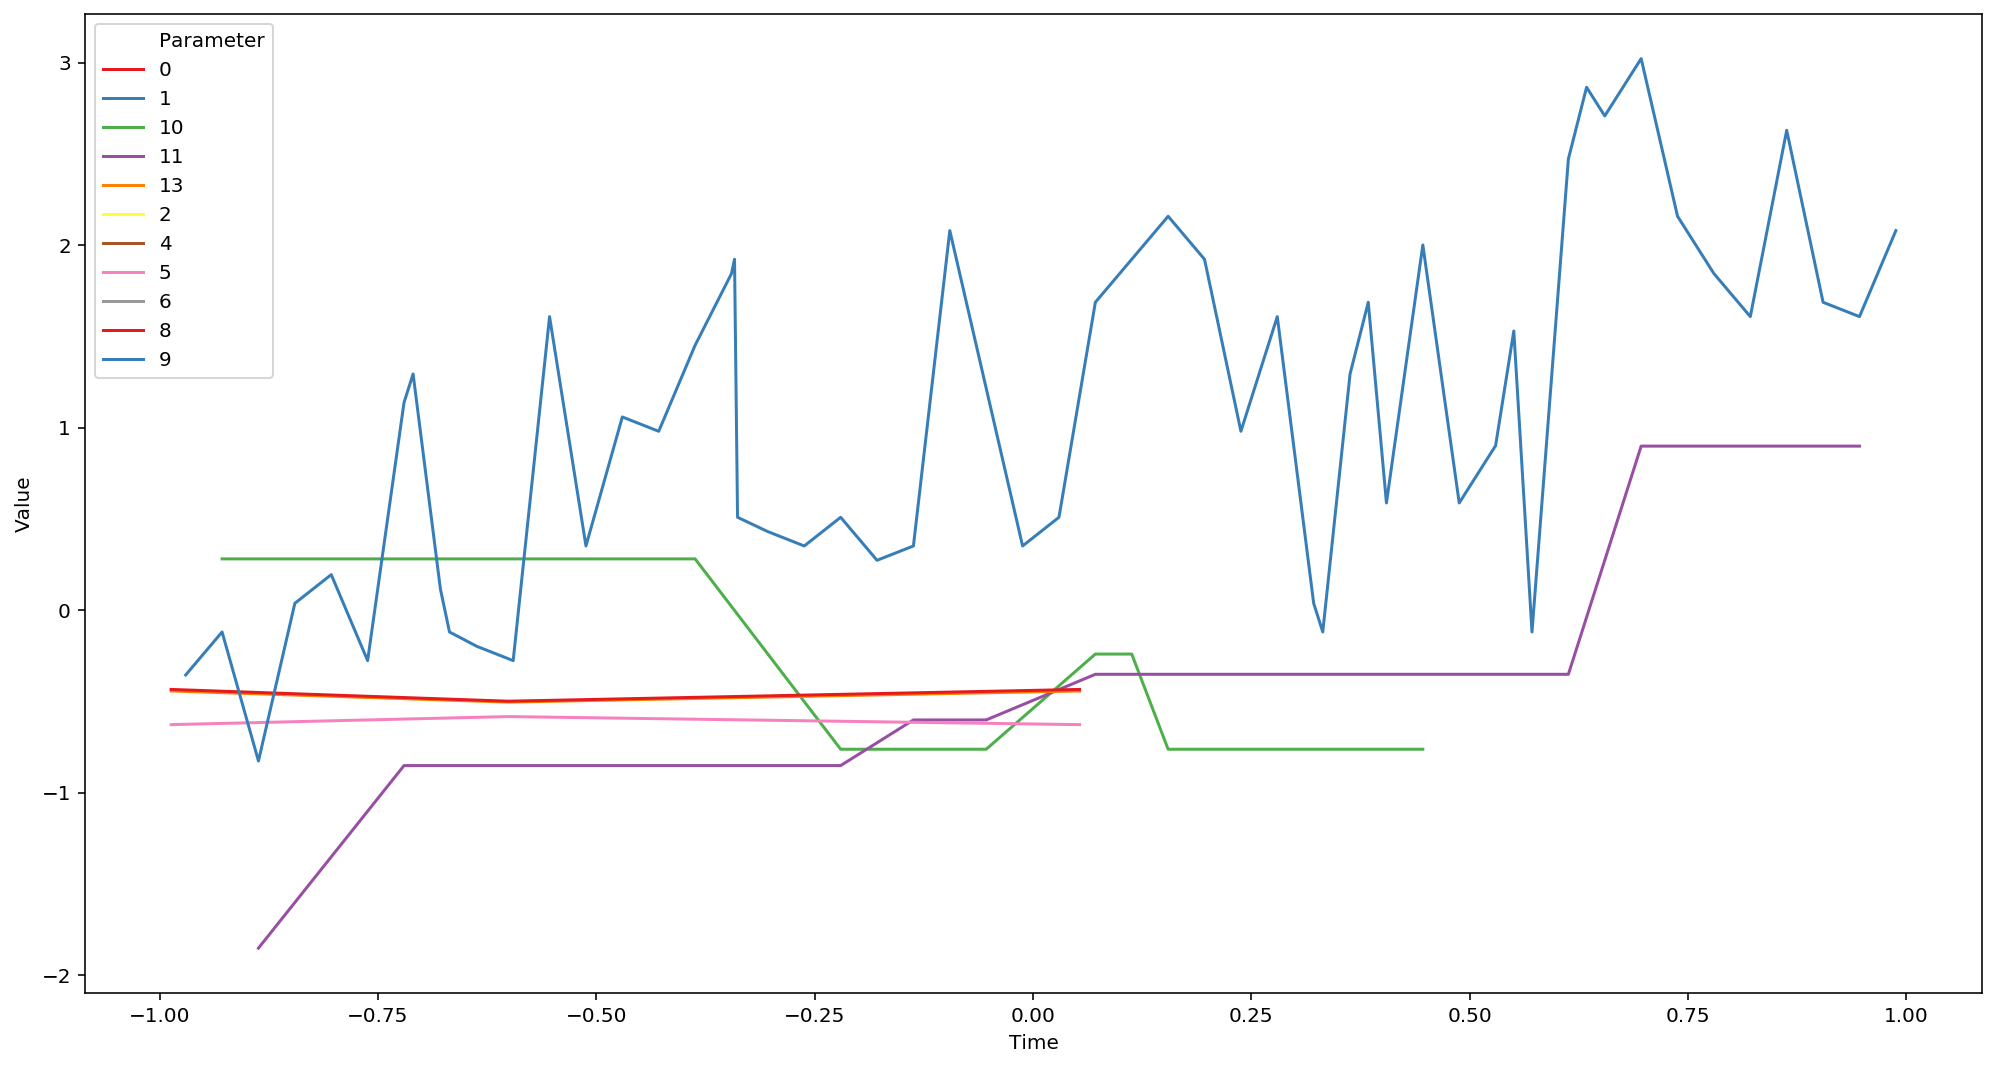

In [14]:
import seaborn as sns
df = pd.read_hdf("data/Physionet2012/data.hdf5", data.keys[300])
df.Parameter = df.Parameter.map(str)
F, ax = plt.subplots(1,1, figsize=(17,9))
df = df[df.Parameter.map(int) < 14]
sns.lineplot(data=df, 
             x=df.index, y="Value", hue="Parameter", ax=ax, 
             palette=sns.color_palette("Set1", len(df.Parameter.unique())))

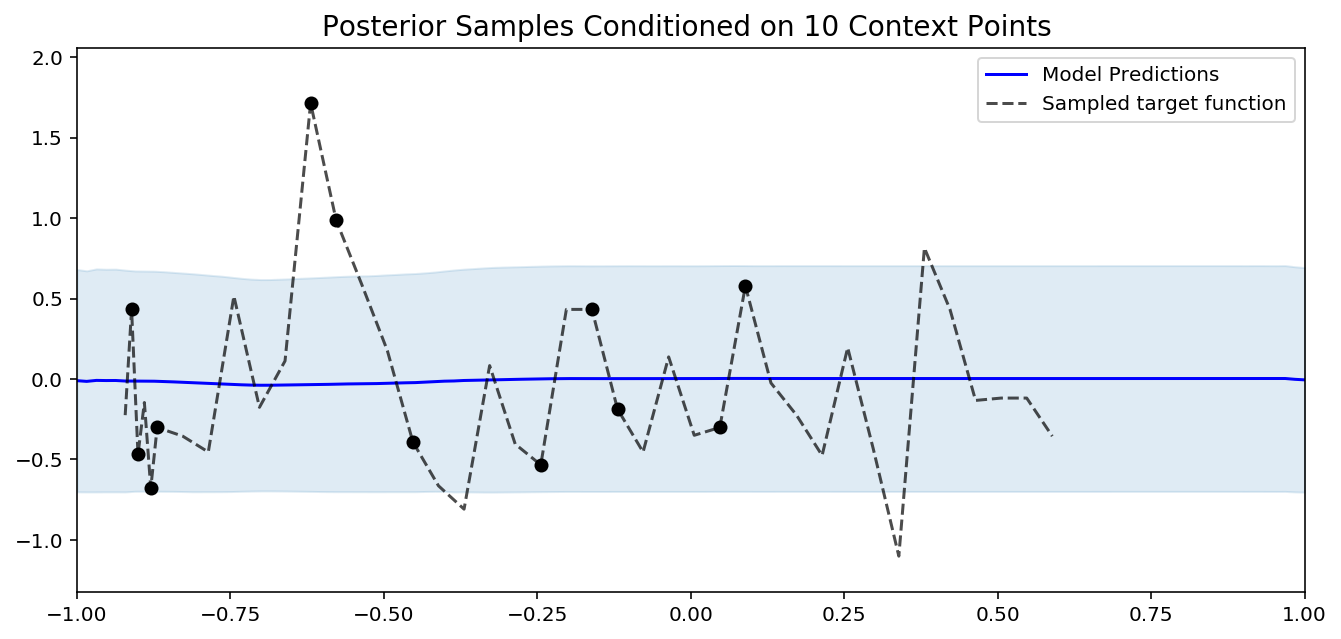

In [24]:
eg = 1200
#data = data_train
n_cntxt = .3
X = data[eg][0]["X"]
y = data[eg][0]["y"]

from ntbks_viz import plot_posterior_predefined_cntxt
plot_posterior_predefined_cntxt(data_trainers['physionet2012/transformer_gnp'].module_, 
                                true_func=(X.unsqueeze(0), y.unsqueeze(0)),
                               X_cntxt=None, 
                               Y_cntxt=None,
                               n_trgt=128,
                               n_samples=1,
                               is_plot_std=True,
                               train_min_max=(-1,1),
                               title="Posterior Samples Conditioned on {} Context Points ".format(10),
                               is_sparse_channels=True,
                               get_cntxt_trgt=CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=n_cntxt, 
                                                                                             max_n_indcs=n_cntxt),
                                                             targets_getter=get_all_indcs,
                                                             is_add_cntxts_to_trgts=False),
                               y_idx=9
                               )

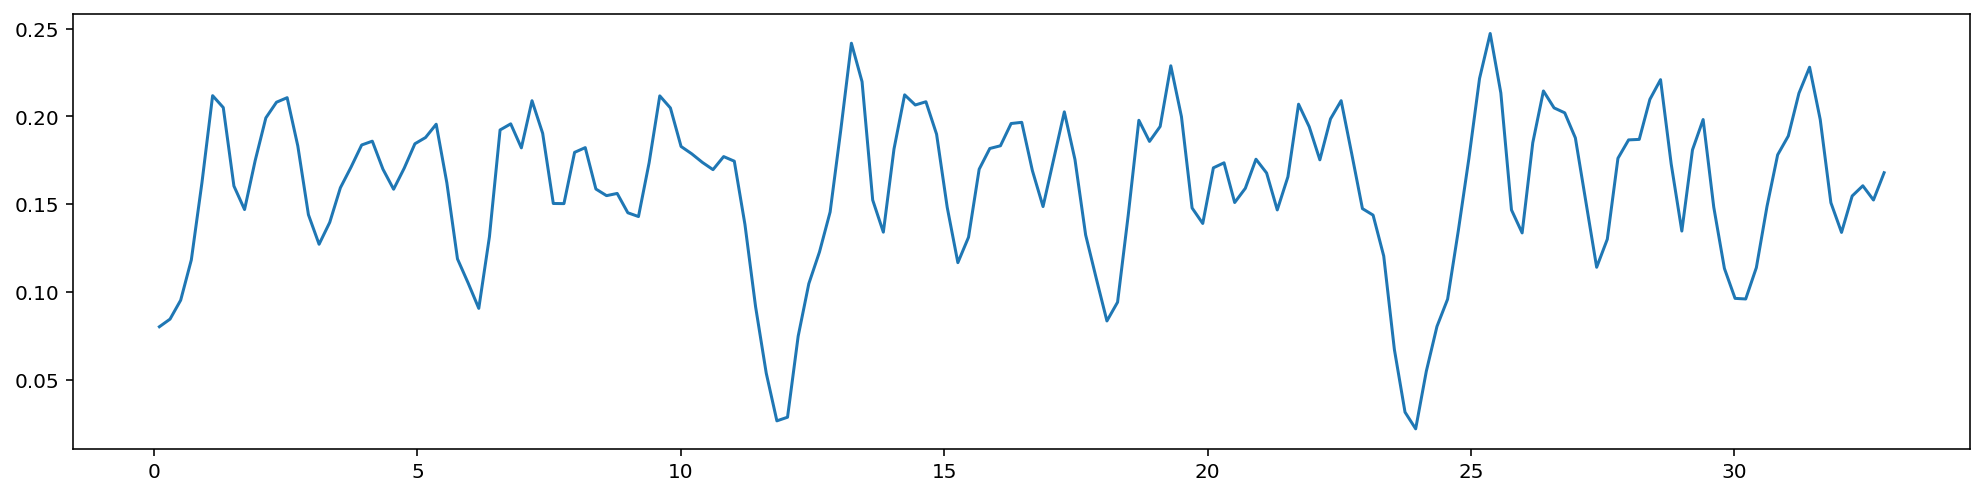

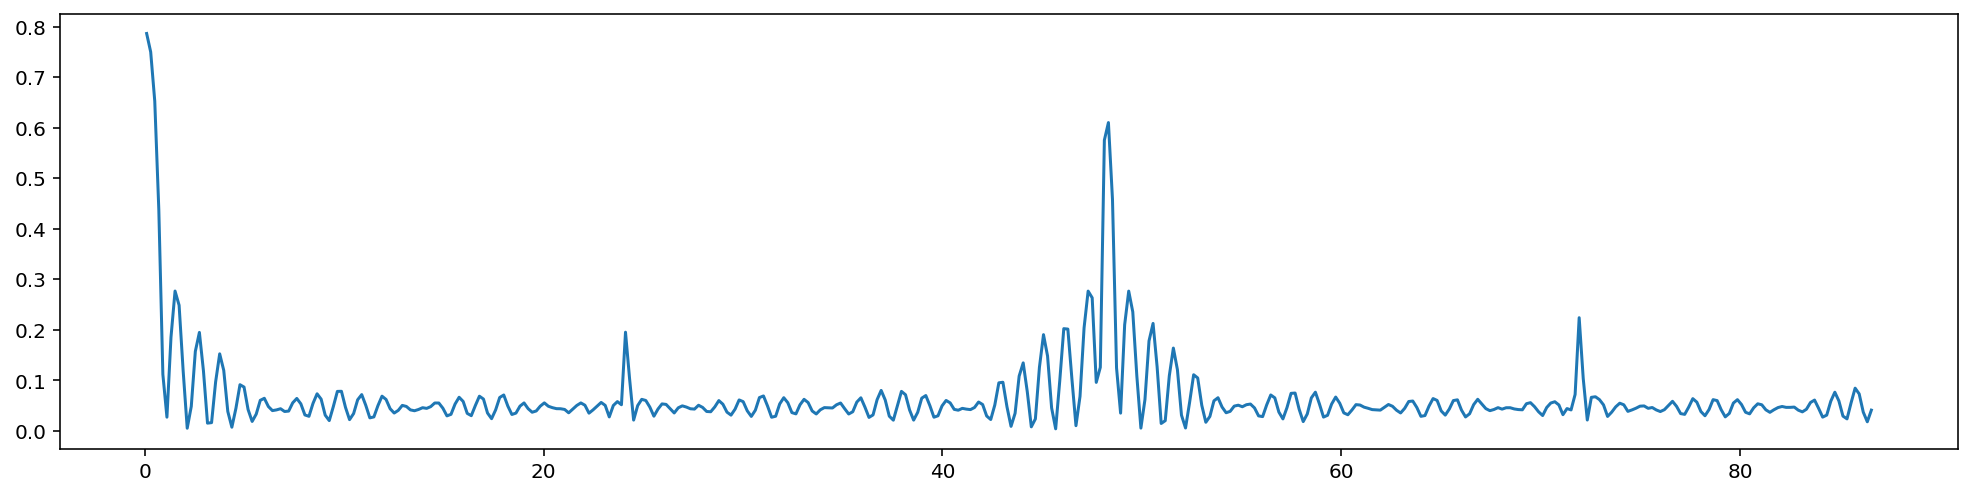

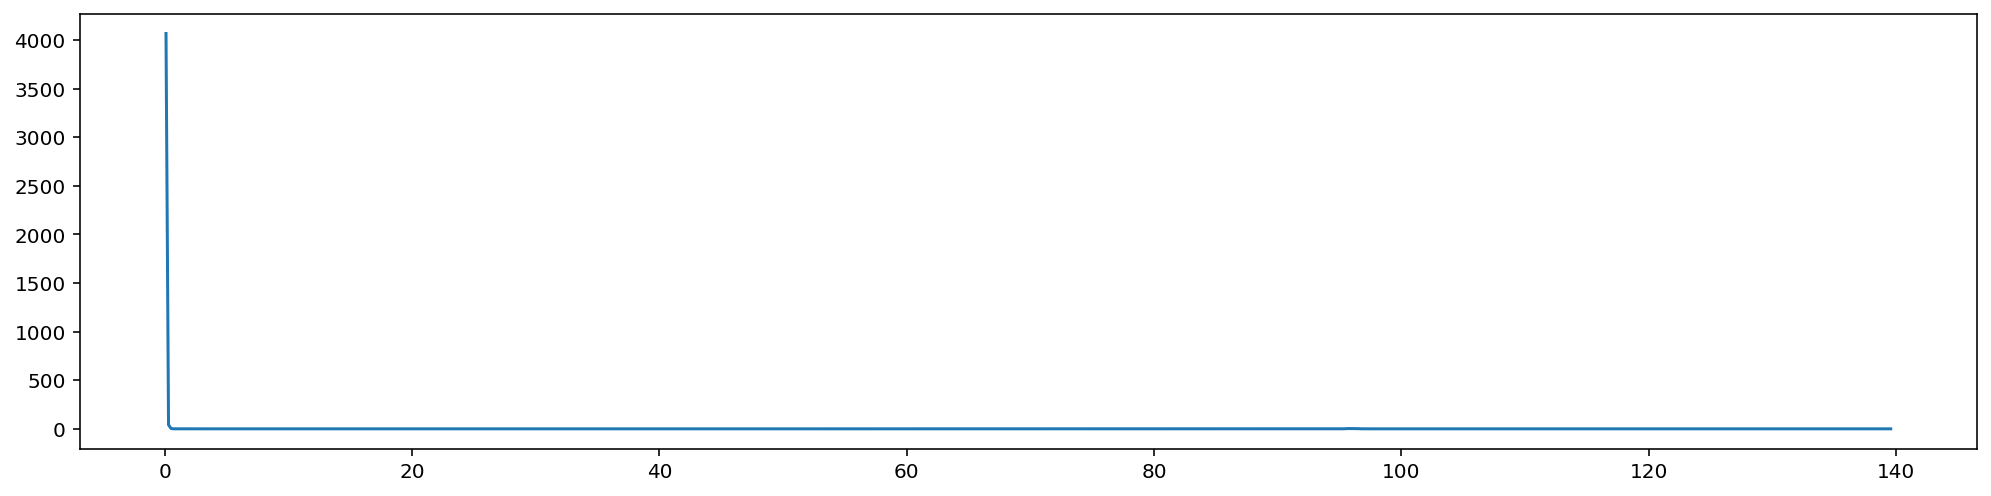

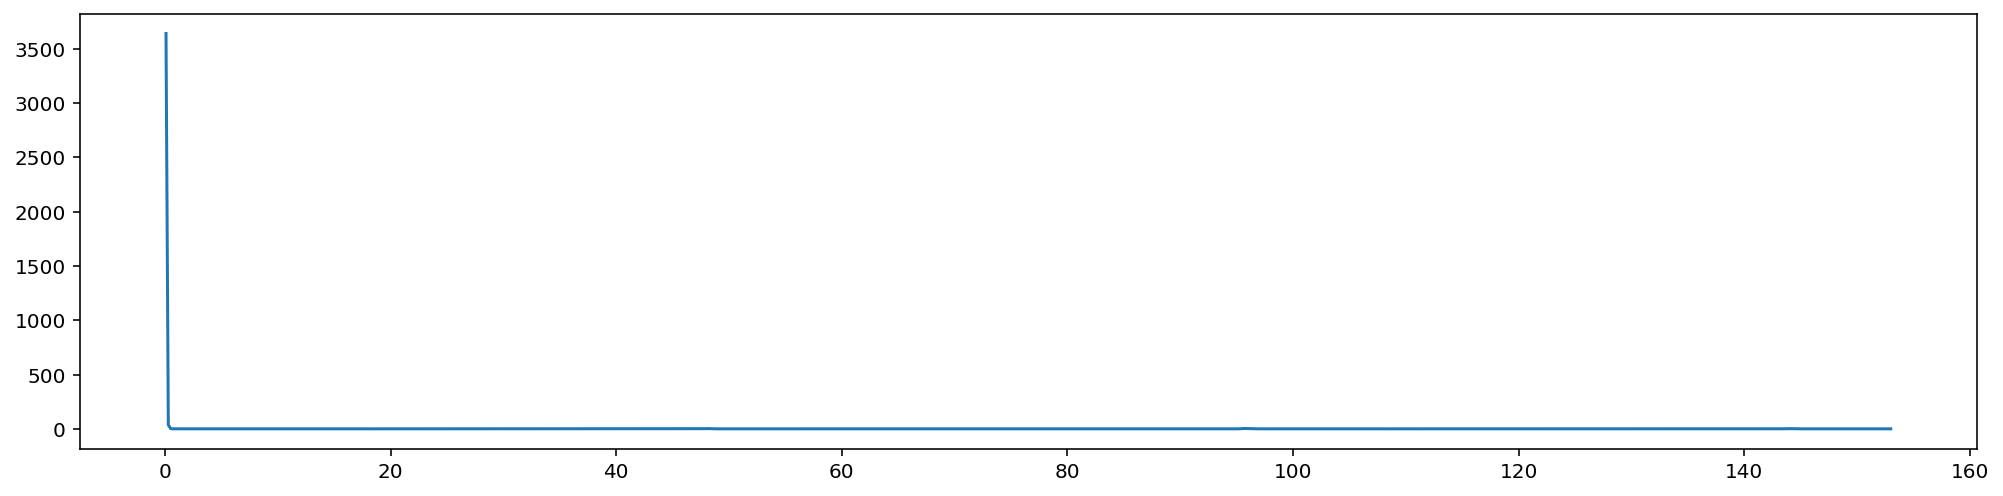

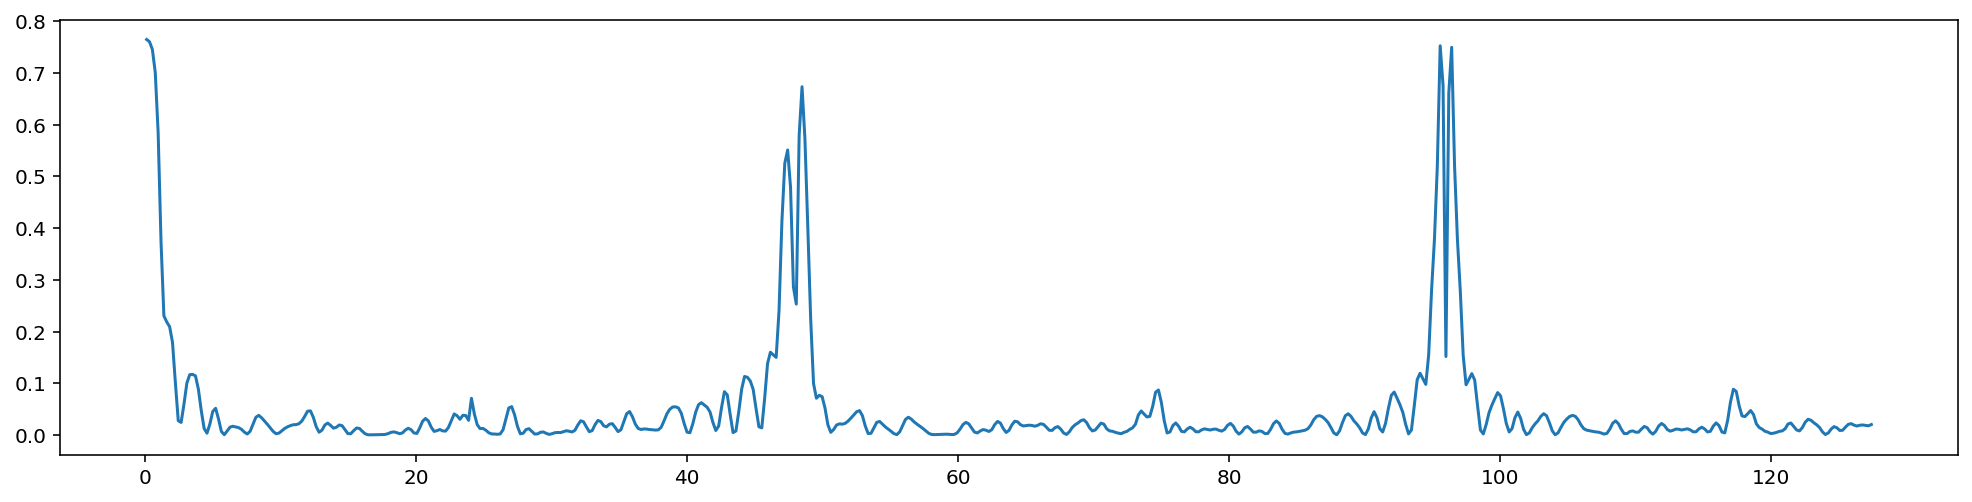

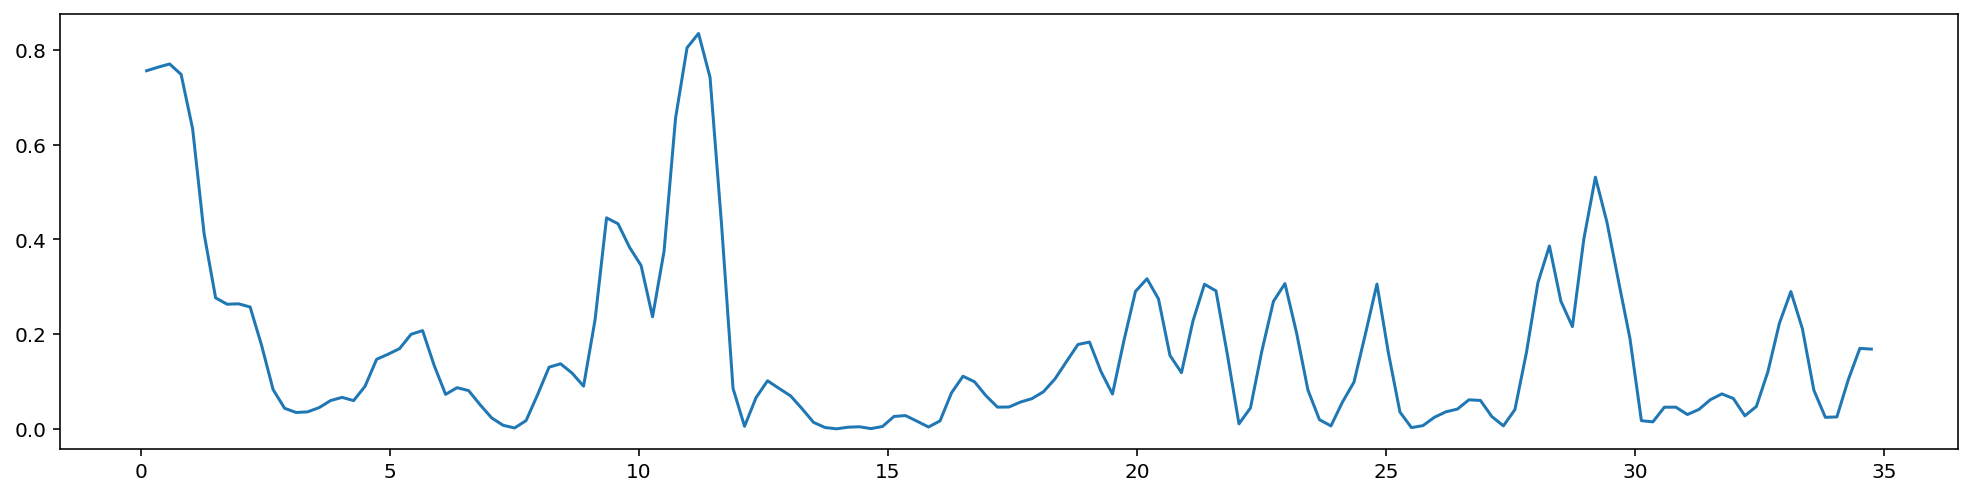

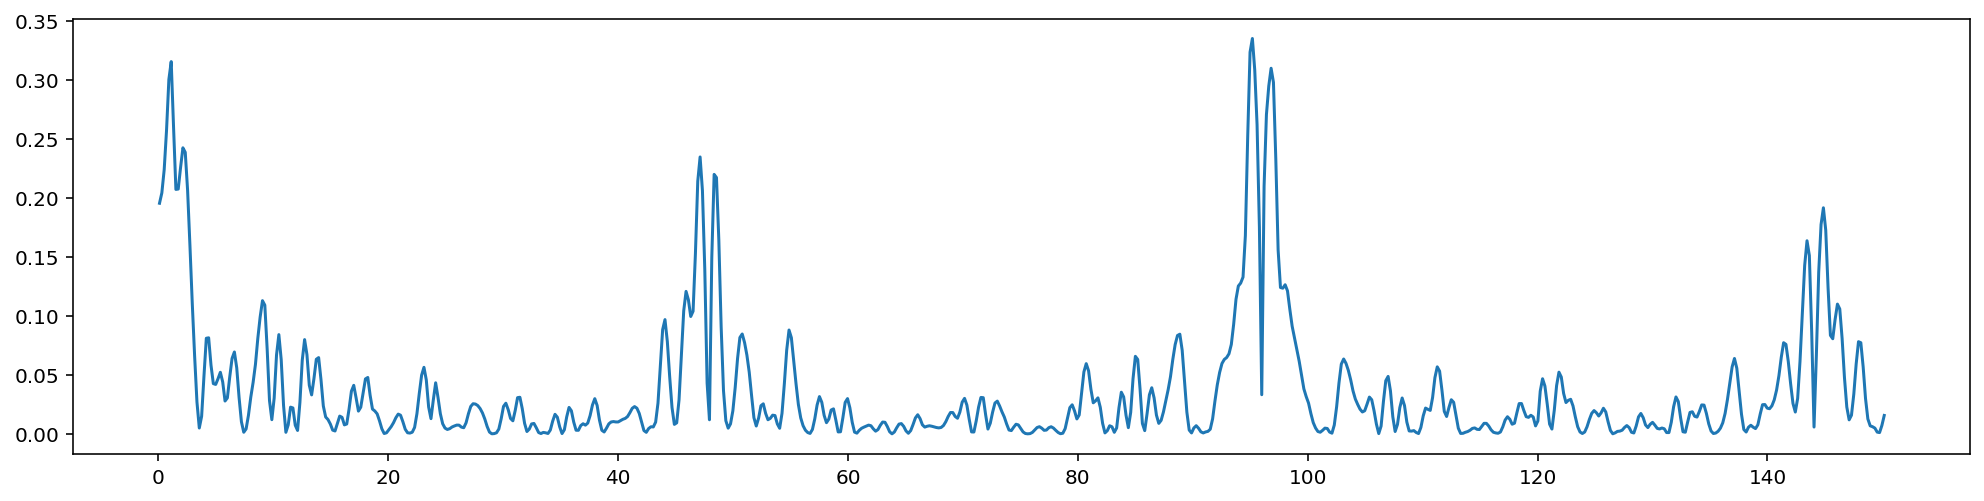

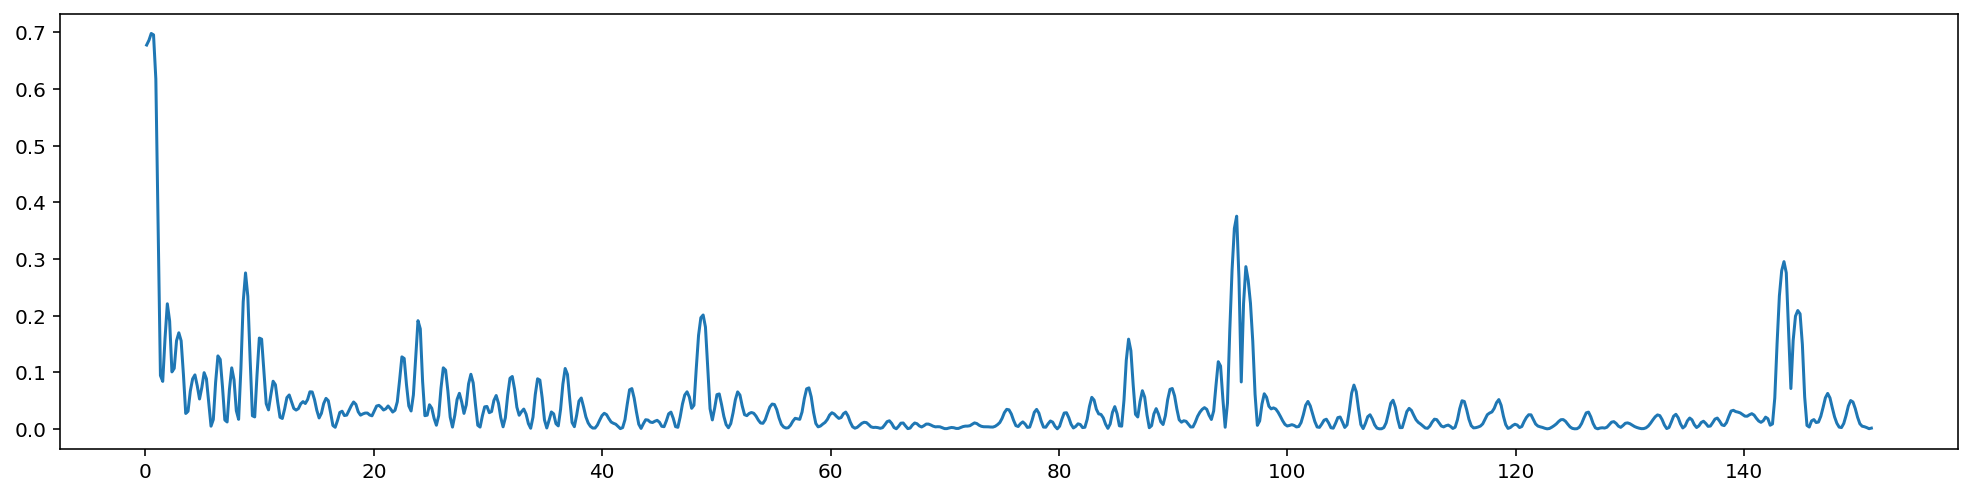

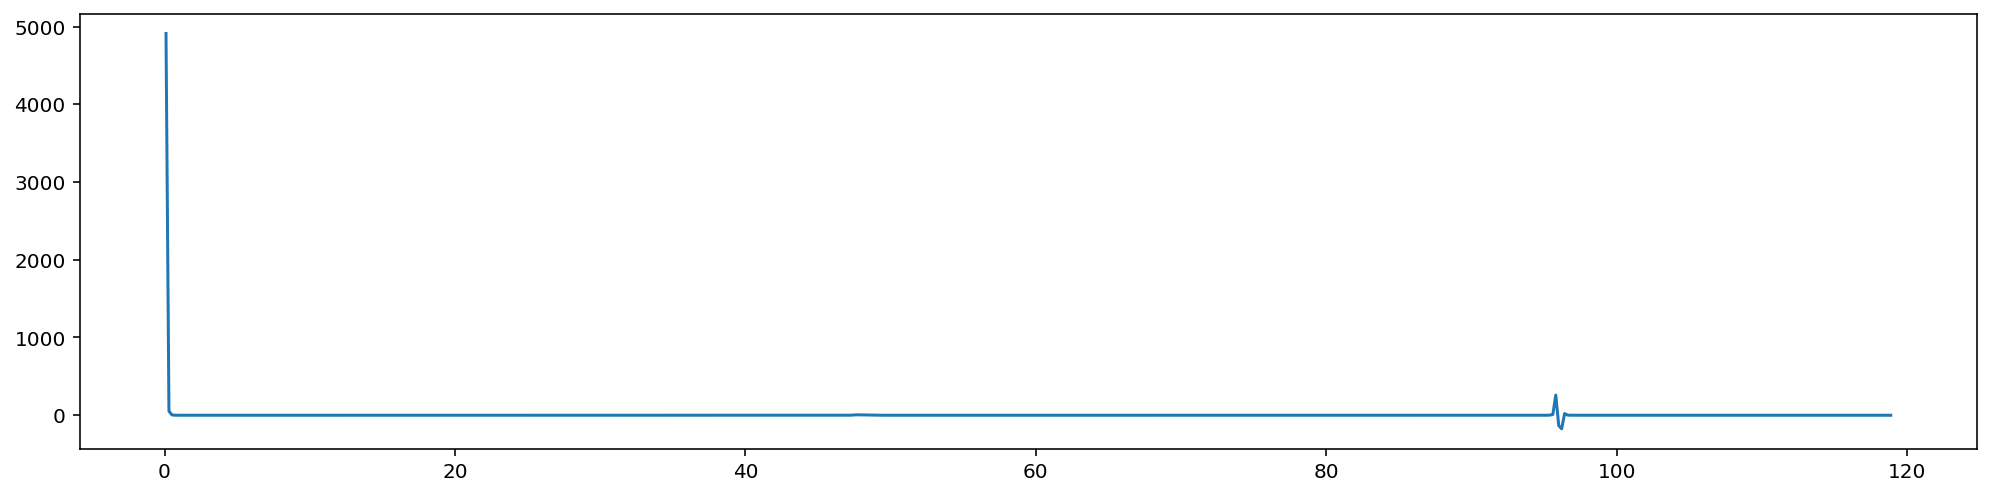

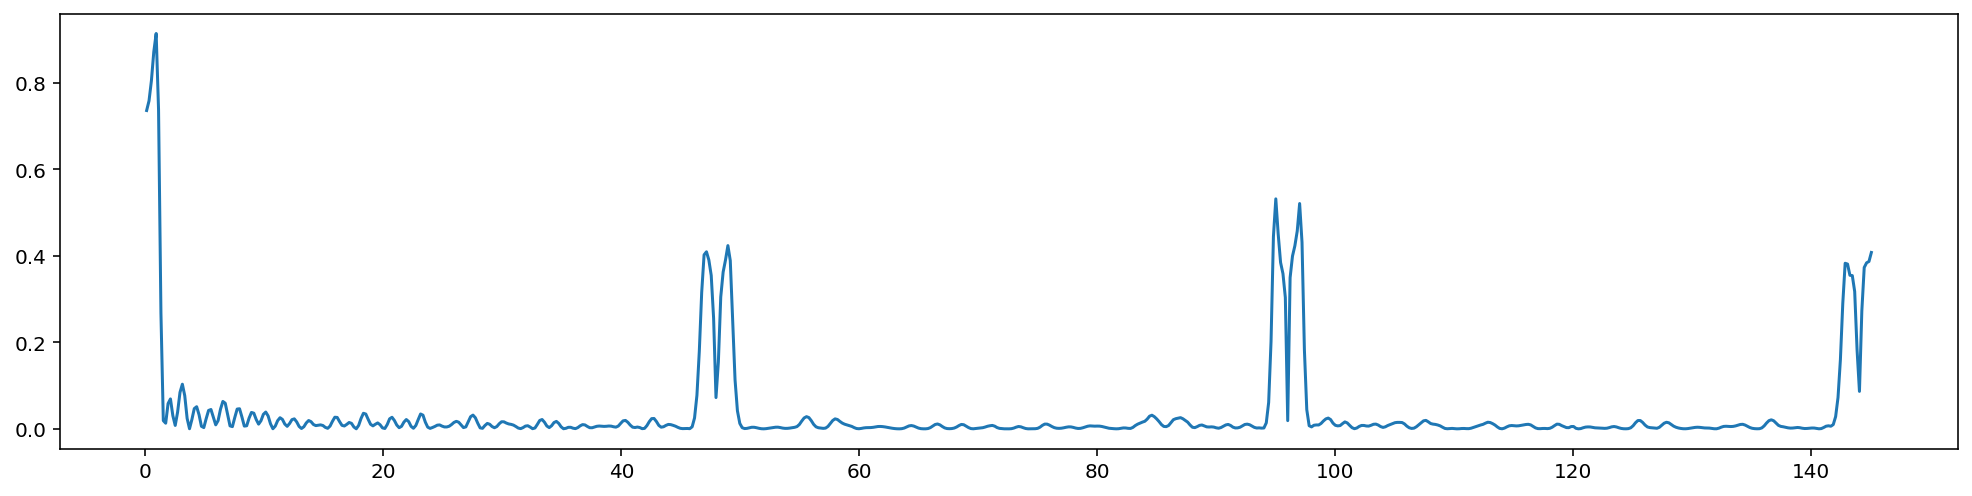

In [32]:
from astropy.timeseries import LombScargle

pgrams = []

min_diff = 1
for i in range(10):
    df = pd.read_hdf("data/Physionet2012/data.hdf5", data.keys[i])
    for j in df.Parameter.unique():
        selected = df.loc[df.Parameter == j]
        x = (selected.index.values + 1)/2
        if len(x) > 10: 
            y = selected.Value.values
            
            frequency, power = LombScargle(x, y).autopower()
            
            F, ax = plt.subplots(1,1, figsize=(17,4))
            ax.plot(frequency, power)
            
            break

In [ ]:
from astropy.timeseries import LombScargle

# highest frequency with more than 0.5 amplitude
pgrams = []

max_freq = 0

for i in range(500):
    df = pd.read_hdf("data/Physionet2012/data.hdf5", data.keys[i])
    for j in df.Parameter.unique():
        selected = df.loc[df.Parameter == j]
        x = (selected.index.values + 1)/2
        if len(x) > 10: 
            y = selected.Value.values
            
            frequency, power = LombScargle(x, y).autopower()
            
            max_freq = max(max_freq, arr[arr[:,1] > 0.5][:,0].max())
            
print("highest frequency with more than 0.5 amplitude", max_freq)
# highest frequency with more than 0.5 amplitude 97.00104275286758